In [1]:
print(__doc__)
import time
start_time = time.time()
from copy import deepcopy, copy
import math
import scipy.io as sio
import shutil
import os
from random import shuffle
import numpy as np
from pylab import *
# from featext2 import *
import matplotlib.pyplot as plt
%matplotlib inline 
#matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D #, axes3d
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, ParameterGrid, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RandomizedLasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif, SelectFdr
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from collections import OrderedDict
import re
import datetime
import urllib
import tarfile
import joblib
from joblib import Parallel, delayed, Memory
from tempfile import mkdtemp
import copy_reg
import types
import itertools
from itertools import compress
from collections import Counter

#import multiprocessing
def _pickle_method(m):
    if m.im_self is None:
        return getattr, (m.im_class, m.im_func.func_name)
    else:
        return getattr, (m.im_self, m.im_func.func_name)
copy_reg.pickle(types.MethodType, _pickle_method)

h = .2  # step size in the mesh
names = ["NearNb", "RBFSVM1", "NaiveBayes", "MLP1", "Log.Regr", "RandFor", "AdaBoost", "EnsembleMLP"]
classifiers = [
    KNeighborsClassifier(5),
    SVC(gamma='auto', C=1),
    MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
]

cv = StratifiedKFold(n_splits=5, random_state=42)
parameters_clf = [{'n_neighbors':range(3,10)},
              {'kernel':['rbf'], 'C':[0.01,0.1,1,10,100,1000]},
              {'solver':['lbfgs'], 'alpha':[1e-5,1e-2], 'hidden_layer_sizes':[(10,10),(50,50),(100,100)]},
              {'max_depth':[4,7,10,20],'n_estimators':[5,10,20],'max_features':[20,35,50]},
              {'solver':['lbfgs'], 'alpha':[1e-5], 'hidden_layer_sizes':[(len(names)-1,len(names)-1),(len(names)-1,2)]}
             ]
makepipe_parameters_clf = [{'classifier__'+key:p[key] for key in p} for p in parameters_clf]
makepipe_parameters_clf += [{'feature_selection__k': (750,500,100), 'feature_selection__score_func': [mutual_info_classif]},
                            {'decomp__n_components': (100,50)}]
metric = ['accuracy','f1']
dataset = 0 # all datasets (0), dataset 1-2 (1), dataset 3 (2), dataset4 (3)
download = 1 # Download pre-computed (1) data or compute them anew (0)
window = 1024

Automatically created module for IPython interactive environment


In [2]:
def make_pipe_clf(scaler,feature_selection,decomp,clf):
    order = 1
# order = 1 : first perform feature selection and then apply PCA
# order = 0 : first apply PCA and then reduce the transformed features
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                    ('classifier', clf) ])
#     else:
#         pipeline = Pipeline([('scaler', scaler),
#                     ('decomp', decomp ),                 
#                     ('feature_selection', feature_selection),        
#                     ('classifier', clf) ])
    return pipeline
###########################################################################################
def make_pipe(scaler,feature_selection,decomp,order):
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                     ])
    else:
        pipeline = Pipeline([('scaler', scaler),
                    ('decomp', decomp ),                 
                    ('feature_selection', feature_selection),        
                     ])
    return pipeline

In [3]:
def get_feat_id(feat_ind, printit = 0): 
    sample_window = 1024
    ##  features:                                                                                  ||      if         ##
##  |----------> time domain      :                                                            || samples = 1024  ##
##  |------------|---> phinyomark : 11+3{shist} -----------------------------> = 14+0.0samples ||             14  ##
##  |------------|---> golz       : 10+samples{acrol} -----------------------> = 10+1.0samples ||           1034  ##
##  |----------> frequency domain :                                                                               ##
##  |------------|---> phinyomark : 3{arco}+4{mf}+3(samples/2+1){RF,IF} -----> =  9+1.0samples ||           1033  ##
##  |------------|---> golz       : 2(samples/2+1){AF,PF} -------------------> =  2+1.0samples ||           1027  ##
##  |------------|--------|-------alltogether--------------------------------> = 35+3.0samples || numfeat = 3108  ##
    # get the feat inds wrt their source : 3rd level
    norm_time_phin = range(0,14)
    norm_freq_phin = range(norm_time_phin[-1] + 1, norm_time_phin[-1] + 9 + sample_window + 1)
    norm_time_golz = range(norm_freq_phin[-1] + 1, norm_freq_phin[-1] + 10 + sample_window + 1)
    norm_freq_golz = range(norm_time_golz[-1] + 1, norm_time_golz[-1] + 2 + sample_window + 1)
    # get the feat inds wrt their domain : 2nd level 
    norm_time_feats = norm_time_phin + norm_time_golz
    norm_freq_feats = norm_freq_phin + norm_freq_golz
    # get the feat inds wrt their prefeat: 1st level 
    norm_feats = norm_time_feats + norm_freq_feats
#     print(norm_time_phin,norm_time_golz)

    # get the feat inds wrt their source : 3rd level
#     np.arange(norm_feats[-1]+1,norm_feats[-1]+1+len(norm_feats))
    disp = norm_feats[-1]+1
    ftfn_time_phin = range(disp ,disp + 14)
    ftfn_freq_phin = range(ftfn_time_phin[-1] + 1, ftfn_time_phin[-1] + 9 + sample_window + 1)
    ftfn_time_golz = range(ftfn_freq_phin[-1] + 1, ftfn_freq_phin[-1] + 10 + sample_window + 1)
    ftfn_freq_golz = range(ftfn_time_golz[-1] + 1, ftfn_time_golz[-1] + 2 + sample_window + 1)
    # get the feat inds wrt their domain : 2nd level 
    ftfn_time_feats = ftfn_time_phin + ftfn_time_golz
    ftfn_freq_feats = ftfn_freq_phin + ftfn_freq_golz
    # get the feat inds wrt their prefeat: 1st level 
    ftfn_feats = ftfn_time_feats + ftfn_freq_feats

    # create the final "reference dictionary"
    id_list = [np.zeros((len(ftfn_feats + norm_feats),1)) for i in range(3)] #3 np.arrays, id_list[0] = level 1 etc
    id_list[0][:norm_feats[-1]+1] = 0 # 0 signifies norm / 1 signifies ft/fn
    id_list[0][norm_feats[-1]+1:] = 1

    id_list[1][:norm_time_phin[-1]+1] = 0 #0 signifies time / 1 signifies freq
    id_list[1][norm_time_phin[-1]+1:norm_freq_phin[-1]+1] = 1
    id_list[1][norm_freq_phin[-1]+1:norm_time_golz[-1]+1] = 0
    id_list[1][norm_time_golz[-1]+1:norm_freq_golz[-1]+1] = 1
    id_list[1][norm_freq_golz[-1]+1:ftfn_time_phin[-1]+1] = 0
    id_list[1][ftfn_time_phin[-1]+1:ftfn_freq_phin[-1]+1] = 1
    id_list[1][ftfn_freq_phin[-1]+1:ftfn_time_golz[-1]+1] = 0
    id_list[1][ftfn_time_golz[-1]+1:] = 1

    id_list[2][:norm_freq_phin[-1]+1] = 0 #0 signifies phinyomark / 1 signifies golz
    id_list[2][norm_freq_phin[-1]+1:norm_freq_golz[-1]+1] = 1
    id_list[2][norm_freq_golz[-1]+1:ftfn_freq_phin[-1]+1] = 0
    id_list[2][ftfn_freq_phin[-1]+1:] = 1 
    
    full_path_id = [np.zeros((len(feat_ind),5)) for i in range(len(feat_ind))]
   
    for ind, val in enumerate(feat_ind):

        full_path_id[ind] = [val, id_list[2][val], id_list[1][val], id_list[0][val]]

        if (printit==1):
            if(full_path_id[ind][1]==0):
                lvl3 = 'Phin'
            else:
                lvl3 = 'Golz'
            if(full_path_id[ind][2]==0):
                lvl2 = 'Time'
            else:
                lvl2 = 'Freq'
            if(full_path_id[ind][3]==0):
                lvl1 = 'Norm'
            else:
                lvl1 = 'Ft/Fn'
            print(feat_ind[ind],featnames[val%(norm_feats[-1]+1)],lvl3,lvl2,lvl1)
    
    return(full_path_id,norm_time_feats,norm_freq_feats)        

In [4]:
def get_feat_occ(feat_masks):
    #get the number of occurences for each feature after SelectKbest
#     print("If it ain't working, just make sure you're adding the lists instead of concatenating them,")
#     print("if the input isn't a single list you'll get the unhashable error")
    feat_occ = Counter(feat_masks)
    return feat_occ 

In [5]:
########################################## Feature Names ###########################################################
####################################################################################################################
##  features:                                                                                  ||      if         ##
##  |----------> time domain      :                                                            || samples = 1024  ##
##  |------------|---> phinyomark : 11+3{shist} -----------------------------> = 14+0.0samples ||             14  ##
##  |------------|---> golz       : 10+samples{acrol} -----------------------> = 10+1.0samples ||           1034  ##
##  |----------> frequency domain :                                                                               ##
##  |------------|---> phinyomark : 3{arco}+4{mf}+3(samples/2+1){RF,IF} -----> =  9+1.0samples ||           1033  ##
##  |------------|---> golz       : 2(samples/2+1){AF,PF} -------------------> =  2+1.0samples ||           1027  ##
##  |------------|--------|-------alltogether--------------------------------> = 35+3.0samples || numfeat = 3108  ##
####################################################################################################################
## Time Domain Phinyomark feats
featnames = ['intsgnl', 'meanabs', 'meanabsslp', 'ssi', 'var', 'rms', 'rng', 'wavl', 'zerox', 'ssc', 'wamp', 
             'shist1', 'shist2', 'shist3']                                                   # 11+3{shist}
## Frequency Domain Phinyomark feats
featnames += ['arco1', 'arco2', 'arco3', 'mnf', 'mdf', 'mmnf', 'mmdf']                       # 3{arco}+4{mf}
featnames += ['reFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{RF}
featnames += ['imFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{IF}
## Time Domain Golz feats
featnames += ['meanv', 'stdr', 'mx', 'rngx', 'rngy', 'med', 'hjorth', 'sentr', 'se', 'ssk']  # 10
featnames += ['acrol{:04d}'.format(i) for i in range(window)]                                # samples{acrol}
## Frequency Domain Golz feats
featnames += ['amFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{AF}
featnames += ['phFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{PF}
# featnames += ['ffaf']                                                                        # 1{ffaf}

In [6]:
temps = range(len(featnames))
_,tf,ff = get_feat_id(temps)

In [9]:
# datasets = np.load('newfeatures_newdata_NOsample_1024_20_10_10000_XYsplit.npz')
# X = datasets['Xsp']
# Y = datasets['Ysp']

# ================ 21/07
# filename = 'tmp/features/1024_20/newfeatures_testdata_NOsample_trans_1024_20_10_10000_XYsplit.npz'
# filename1 = 'tmp/features/1024_20/newfeatures_newdata2_NOsample_trans_1024_20_10_10000_XYsplit.npz'
# Xsp = np.load(filename)['Xsp'][0:2,:]
# Ysp = np.load(filename)['Ysp'][0:2]
# Xsp1 = np.load(filename1)['Xsp'][2,:]
# Ysp1 = np.load(filename1)['Ysp'][2]
# ================ 27/07
filename = 'tmp/features/1024_20/newfeatures_newdata1and2_NOsample_1024_20_10_10000_XYsplit.npz'
Xsp = np.load(filename)['Xsp'][1,:]
Ysp = np.load(filename)['Ysp'][1][:-4]
for i in range(len(Xsp)):
    Xsp[i] = Xsp[i][:-4,:]
    print Xsp[i].shape, Ysp.shape

(8820, 3107) (8820,)
(8820, 3107) (8820,)
(8820, 6214) (8820,)


In [8]:
# for j in range(Xsp1.shape[0]):
#     Xsp1[j] = Xsp1[j][:8730,:]
# Ysp1 = Ysp1[:8730]
# print([ Xsp[i][j].shape for i in range(len(Xsp)) for j in range(len(Xsp[i]))])
# print([ Xsp[i].shape for i in range(len(Xsp))])
# print([ Xsp1[j].shape for j in range(len(Xsp1))])

In [10]:
# ================== 21/07 
# X_new = {}
# for i in range(Xsp.shape[1]):
#     X_new[i] = np.concatenate((Xsp[0][i][::2,:],Xsp[1][i][::2,:]),axis=0)
# X_new = [i for _,i in X_new.items()]
# #X_new = np.array(X_new)
# #print X_new.shape
# for i in range(len(X_new)):
#     print X_new[i].shape
# Y_new = np.concatenate((Ysp[0][::2],Ysp[1][::2]),axis=0)


In [11]:
# newfile='2_fingers_6_surfaces.npz'
# np.savez(newfile,X_new=X_new,Y_new=Y_new,Xsp1=Xsp1[2],Ysp1=Ysp1[2])

In [14]:
def surface_split1(data_X, data_Y):
    surfaces = np.split(data_X,6)
    surf_labels = np.split(data_Y,6)
#     surfaces = [np.empty_like(surfaces_pre[i]) for i in range(6)]
#     surf_labels = [np.empty_like(surf_labels_pre[i]) for i in range(6)]

#     for i in range(6):
# #         inds = range(6)
#         surfaces[i] = np.concatenate((surfaces_pre[i], surfaces_pre[inds[1]]), axis = 0)
#         surf_labels[i] = np.concatenate((surf_labels_pre[i], surf_labels_pre[inds[1]]), axis = 0)
    return surfaces, surf_labels

def surface_split2(data_X, data_Y):
    surfaces_pre = np.split(data_X,12)
    surf_labels_pre = np.split(data_Y,12)
    surfaces = [np.empty_like(surfaces_pre[i]) for i in range(6)]
    surf_labels = [np.empty_like(surf_labels_pre[i]) for i in range(6)]

    for i in range(6):
        inds = range(i,12,6)
        surfaces[inds[0]] = np.concatenate((surfaces_pre[inds[0]], surfaces_pre[inds[1]]), axis = 0)
        surf_labels[inds[0]] = np.concatenate((surf_labels_pre[inds[0]], surf_labels_pre[inds[1]]), axis = 0)
    return surfaces, surf_labels

In [11]:
#====== 25/07
def feat_subsets(data,fs_ind):
#     data = X_new[fs_ind]
    _,tf,ff = get_feat_id(range(len(featnames)))
    ofs = 3107
    amfft_inds = []
    temp1 = deepcopy(data)
    
    for i in range(len(featnames)):
        if (featnames[i].startswith('amFFT')):
            amfft_inds.append(i)

    if (fs_ind == 2):
        ff2 = [ff[i]+ofs for i in range(len(ff))]
        tf2 = [tf[i]+ofs for i in range(len(tf))]
        amfft2 = [amfft_inds[i]+ofs for i in range(len(amfft_inds))]
        freqf = ff2 + ff
        timef = tf2 + tf
        amfft = amfft_inds + amfft2
    else:
        freqf = ff
        timef = tf
        amfft = amfft_inds

    X_amfft = temp1[:,amfft]
    X_time = np.delete(temp1,freqf,axis=1)
    X_freq_all = np.delete(temp1,timef,axis=1)
    X_both = data
    return X_amfft, X_freq_all, X_time, X_both

In [15]:
# =================== 21/07
# surf1, surflab1 = surface_split(Xsp1[2][2], Ysp1[2]) 
# surf, surfla = [], []
# for i in range(Xsp1.shape[0]): # for each featureset
#     surf1, surfla1 = surface_split(X_new[i], Y_new)
#     surf2, surfla2 = surface_split(Xsp1[i], Ysp1)
#     tmpsurf = surf1 + surf2
#     tmpsurfla = surfla1 + surfla2
#     tmpsurfsubfeat = []
#     for j in range(len(tmpsurf)): # for each surface
#         tmpsurfsubfeat.append(feat_subsets(tmpsurf[j],i)) # keep all subfeaturesets
# #     surf.append(surf1 + surf2)
#     surf.append(tmpsurfsubfeat)
#     surfla.append(surfla1 + surfla2)
# surf = np.array(surf).transpose() # array dims: (subfeaturesets, surfaces, featuresets)
# surfla = np.array(surfla).transpose()
# print surf.shape, surfla.shape

# =================== 27/07
surf, surfla = [], []
for i in range(Xsp.shape[0]): # for each featureset
    surf1, surfla1 = surface_split1(Xsp[i], Ysp)
    tmpsurf = surf1
    tmpsurfla = surfla1
    tmpsurfsubfeat = []
    for j in range(len(tmpsurf)+1): # for each surface
        print i,j,len(surf1)
        if j == len(tmpsurf):
            tmpsurfsubfeat.append(feat_subsets(tmpsurf[j-1][:-1,:],i)) # keep all subfeaturesets
        else:
            tmpsurfsubfeat.append(feat_subsets(tmpsurf[j],i)) # keep all subfeaturesets
#     surf.append(surf1 + surf2)
    surf.append(tmpsurfsubfeat)
    surfla.append(surfla1)
# surf[-1][-1] = surf[-1][-1][:-1,:]
# surfla[-1][-1] = surfla[-1][-1][:-1]
surf = np.array(surf).transpose()[:,:-1,:] # array dims: (subfeaturesets, surfaces, featuresets)
surfla = np.array(surfla).transpose()
print surf.shape, surfla.shape

0 0 6
0 1 6
0 2 6
0 3 6
0 4 6
0 5 6
0 6 6
1 0 6
1 1 6
1 2 6
1 3 6
1 4 6
1 5 6
1 6 6
2 0 6
2 1 6
2 2 6
2 3 6
2 4 6
2 5 6
2 6 6
(4, 6, 3) (1470, 6, 3)


In [7]:
surffile = '2_fingers_6_surfaces.npz'
np.savez(surffile,surf=surf,surfla=surfla)

In [8]:
surf = np.load(surffile)['surf']
surfla = np.load(surffile)['surfla']
print surf.shape, surfla.shape

(4, 6, 3) (1470, 6, 3)


(1470, 6214) (1470,)


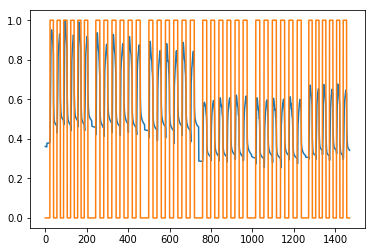

In [9]:
print surf[-1,-1,-1].shape, surfla[:,-1,-1].shape
plt.plot(surf[-1,-1,-1][:,0]/np.max(surf[-1,-1,-1][:,0],axis=0))
plt.hold
plt.plot(surfla[:,-1,-1])

In [47]:
for i in range(3):
    for j in range(4):
        for k in range(6):
            for k2 in range(6):
                fileid = 'tmpresults2/'+filename(i,j,k,k2)+'.npz'
                print i,j,k,k2
                print np.load(fileid)['cm']

0 0 0 0
[[ 0.9171943   0.0828057 ]
 [ 0.08659248  0.91340752]]
0 0 0 1
[[ 0.96688742  0.03311258]
 [ 0.53313253  0.46686747]]
0 0 0 2
[[ 0.96907216  0.03092784]
 [ 0.33981337  0.66018663]]
0 0 0 3
[[ 0.80550344  0.19449656]
 [ 0.1395881   0.8604119 ]]
0 0 0 4
[[ 0.90955414  0.09044586]
 [ 0.46865672  0.53134328]]
0 0 0 5
[[ 0.80509554  0.19490446]
 [ 0.1380597   0.8619403 ]]
0 0 1 0
[[ 0.7414665   0.2585335 ]
 [ 0.00955414  0.99044586]]
0 0 1 1
[[ 0.89573954  0.10426046]
 [ 0.10922867  0.89077133]]
0 0 1 2
[[ 0.85438144  0.14561856]
 [ 0.04898911  0.95101089]]
0 0 1 3


IOError: [Errno 2] No such file or directory: 'tmpresults2/fs_0_subfs_0_tr_1_fs_3.npz'

In [49]:
for i in range(3):
    for j in range(4):
        for k in range(6):
            for k2 in range(6):
                fileid = 'tmpresults2/'+filename(i,j,k,k2)+'.npz'
                print i,j,k,k2
                print np.load(fileid)['cm']

0 0 0 0
[[ 0.9171943   0.0828057 ]
 [ 0.08659248  0.91340752]]
0 0 0 1
[[ 0.96688742  0.03311258]
 [ 0.53313253  0.46686747]]
0 0 0 2
[[ 0.96907216  0.03092784]
 [ 0.33981337  0.66018663]]
0 0 0 3
[[ 0.80550344  0.19449656]
 [ 0.1395881   0.8604119 ]]
0 0 0 4
[[ 0.90955414  0.09044586]
 [ 0.46865672  0.53134328]]
0 0 0 5
[[ 0.80509554  0.19490446]
 [ 0.1380597   0.8619403 ]]
0 0 1 0
[[ 0.7414665   0.2585335 ]
 [ 0.00955414  0.99044586]]
0 0 1 1
[[ 0.89573954  0.10426046]
 [ 0.10922867  0.89077133]]
0 0 1 2
[[ 0.85438144  0.14561856]
 [ 0.04898911  0.95101089]]
0 0 1 3


IOError: [Errno 2] No such file or directory: 'tmpresults2/fs_0_subfs_0_tr_1_fs_3.npz'

In [10]:
print surf.shape

(4, 6, 3)


In [11]:
# Cross surface validation for 1 surface

cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ;
decomp = PCA(n_components=20)
def filename(i,j,k,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr_'+str(k)+'_ts_'+str(l)

def cross_fit(i,j,k,l,data,labels,data2,labels2,pipe):
    fileid = 'tmpresults1_2ndfinger/'+filename(i,j,k,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k,l
        if k==l: # perform K-fold                  
#             data = surf[j][k][i][::100,:]
#             labels = surfla[k][i][::100]
            folds = cv.split(data, labels)
            cm_all = np.zeros((2,2))
            for fold, (train_ind, test_ind) in enumerate(folds):
                x_train, x_test = data[train_ind], data[test_ind]
                y_train, y_test = labels[train_ind], labels[test_ind]
                model = pipe.fit(x_train,y_train)
                y_pred = model.predict(x_test)
                cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                cm_all += cm/5.
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
#             tr_data = surf[j][k][i]
#             tr_labels = surfla[k][i]
#             ts_data = surf[j][l][i]
#             ts_labels = surfla[l][i]
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            print 'Fitting on '+str(k)+', testing on '+str(l)+'...'
            model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k in range(surf.shape[0]): # for every training surface
        for l in range(surf.shape[0]): # for every testing surface
#             cross_fit(i,j,k,l,surf[k][::100,:],surfla[k][::100],surf[l][::100,:],surfla[l][::100],pipe)
            cross_fit(i,j,k,l,surf[k],surfla[:,k],surf[l],surfla[:,l],pipe)

for i in range(surf.shape[2]): # for every featureset
#     for j in range(surf.shape[0]): # for every subfeatureset
#         if j==surf.shape[0]-1:
#             featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
#         else:
#             featsel = SelectKBest(k='all',score_func= mutual_info_classif)
#         pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
#         init_steps(i,j,surf[j][:][i],surfla[:][i])
    # for every subfeatureset
    [Parallel(n_jobs=-1)([delayed(init_steps) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) for j in range(surf.shape[0])])]
#         for k in range(surf.shape[1]): # for every training surface
#             for l in range(surf.shape[1]): # for every testing surface
#                 cross_fit(i,j,k,l,surf,surfla,pipe)
#             [Parallel(n_jobs=-1)([delayed(cross_fit) (i,j,k,l,surf,surfla,pipe) for l in range(surf.shape[1])])]
            
            

# for i in range(surf.shape[2]): # for every featureset
#     for j in range(surf.shape[0]): # for every subfeatureset
#         if j==surf.shape[0]-1:
#             featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
#         else:
#             featsel = SelectKBest(k='all',score_func= mutual_info_classif)
#         pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
#         for k in range(surf.shape[1]): # for every training surface
# #             for l in range(surf.shape[1]): # for every testing surface
# #                 cross_fit(i,j,k,l,surf,surfla,pipe)
# #             [Parallel(n_jobs=-1)([delayed(cross_fit) (i,j,k,l,surf,surfla,pipe) for l in range(surf.shape[1])])]
#             [Parallel(n_jobs=-1)([delayed(cross_fit) (i,j,k,l,surf[j][k][i][::100,:],surfla[k][i][::100],surf[j][l][i][::100,:],surfla[l][i][::100],pipe) for l in range(surf.shape[1])])]
    
#     print(temp_surf[3].shape, i)
#     X_amfft, X_freq_all, X_time, X_both = feat_subsets(surf[:,i],i)
#     for j in range()

0 0 0 0
0 1 0 0
0 2 0 0
0 3 0 0
0 0 0 1
Fitting on 0, testing on 1...
0 0 0 2
Fitting on 0, testing on 2...
0 0 0 3
Fitting on 0, testing on 3...
0 0 0 4
Fitting on 0, testing on 4...
0 2 0 1
Fitting on 0, testing on 1...
0 0 0 5
Fitting on 0, testing on 5...
0 0 1 0
Fitting on 1, testing on 0...
0 2 0 2
Fitting on 0, testing on 2...
0 0 1 1
0 2 0 3
Fitting on 0, testing on 3...
0 2 0 4
Fitting on 0, testing on 4...
0 0 1 2
Fitting on 1, testing on 2...
0 0 1 3
Fitting on 1, testing on 3...
0 2 0 5
Fitting on 0, testing on 5...
0 1 0 1
Fitting on 0, testing on 1...
0 0 1 4
Fitting on 1, testing on 4...
0 2 1 0
Fitting on 1, testing on 0...
0 0 1 5
Fitting on 1, testing on 5...
0 0 2 0
Fitting on 2, testing on 0...
0 2 1 1
0 0 2 1
Fitting on 2, testing on 1...
0 1 0 2
Fitting on 0, testing on 2...
0 0 2 2
0 3 0 1
Fitting on 0, testing on 1...
0 1 0 3
Fitting on 0, testing on 3...
0 0 2 3
Fitting on 2, testing on 3...
0 0 2 4
Fitting on 2, testing on 4...
0 0 2 5
Fitting on 2, testing on

1 1 3 1
Fitting on 3, testing on 1...
1 3 2 1
Fitting on 2, testing on 1...
1 1 3 2
Fitting on 3, testing on 2...
1 3 2 2
1 1 3 3
1 1 3 4
Fitting on 3, testing on 4...
1 1 3 5
Fitting on 3, testing on 5...
1 3 2 3
Fitting on 2, testing on 3...
1 1 4 0
Fitting on 4, testing on 0...
1 1 4 1
Fitting on 4, testing on 1...
1 3 2 4
Fitting on 2, testing on 4...
1 1 4 2
Fitting on 4, testing on 2...
1 3 2 5
Fitting on 2, testing on 5...
1 1 4 3
Fitting on 4, testing on 3...
1 1 4 4
1 3 3 0
Fitting on 3, testing on 0...
1 3 3 1
Fitting on 3, testing on 1...
1 3 3 2
Fitting on 3, testing on 2...
1 1 4 5
Fitting on 4, testing on 5...
1 3 3 3
1 1 5 0
Fitting on 5, testing on 0...
1 1 5 1
Fitting on 5, testing on 1...
1 1 5 2
Fitting on 5, testing on 2...
1 1 5 3
Fitting on 5, testing on 3...
1 1 5 4
Fitting on 5, testing on 4...
1 1 5 5
1 3 3 4
Fitting on 3, testing on 4...
1 3 3 5
Fitting on 3, testing on 5...
1 3 4 0
Fitting on 4, testing on 0...
1 3 4 1
Fitting on 4, testing on 1...
1 3 4 2
Fi

KeyboardInterrupt: 

In [21]:
## Cross surface validation for 2 surfaces

cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ;
decomp = PCA(n_components=20)
def filename(i,j,k1,k2,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_ts_'+str(l)

def cross_fit(i,j,k1,k2,l,data,labels,data2,labels2,pipe):
    fileid = 'tmpresults2_trans/'+filename(i,j,k1,k2,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k1,k2,l
#         if k1==l or k2==l: # perform K-fold                  
# #             data = surf[j][k][i][::100,:]
# #             labels = surfla[k][i][::100]
#             folds = cv.split(data, labels)
#             cm_all = np.zeros((2,2))
#             for fold, (train_ind, test_ind) in enumerate(folds):
#                 x_train, x_test = data[train_ind], data[test_ind]
#                 y_train, y_test = labels[train_ind], labels[test_ind]
#                 pipe.fit(x_train,y_train)
#                 y_pred = pipe.predict(x_test)
#                 cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
#                 cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#                 cm_all += cm/5.
#             np.savez(fileid,cm=cm_all)
#         else: # perform cross-check
#             tr_data = surf[j][k][i]
#             tr_labels = surfla[k][i]
#             ts_data = surf[j][l][i]
#             ts_labels = surfla[l][i]
        tr_data = data
        tr_labels = labels
        ts_data = data2
        ts_labels = labels2
        print 'Fitting on '+str(k1)+"-"+str(k2)+', testing on '+str(l)+'...'
        pipe.fit(tr_data,tr_labels)
        y_pred = pipe.predict(ts_data)
        cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        np.savez(fileid,cm=cm)

def init_steps(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for l in range(surf.shape[0]): # for every testing surface
                    if l != k1 and l != k2:
        #             cross_fit(i,j,k,l,surf[k][::100,:],surfla[k][::100],surf[l][::100,:],surfla[l][::100],pipe)
                        tr_surf, tr_surfla = np.concatenate((surf[k1],surf[k2]),axis=0), np.concatenate((surfla[:,k1],surfla[:,k2]),axis=0)
                        ts_surf, ts_surfla = surf[l], surfla[:,l]
        #                 print tr_surf.shape, tr_surfla.shape
                        cross_fit(i,j,k1,k2,l,tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

for i in range(surf.shape[2]): # for every featureset
#     for j in range(surf.shape[0]): # for every subfeatureset
#         if j==surf.shape[0]-1:
#             featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
#         else:
#             featsel = SelectKBest(k='all',score_func= mutual_info_classif)
#         pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
#         init_steps(i,j,surf[j][:][i],surfla[:][i])
    # for every subfeatureset
    [Parallel(n_jobs=-1)([delayed(init_steps) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) for j in range(surf.shape[0])])]
#         for k in range(surf.shape[1]): # for every training surface
#             for l in range(surf.shape[1]): # for every testing surface
#                 cross_fit(i,j,k,l,surf,surfla,pipe)
#             [Parallel(n_jobs=-1)([delayed(cross_fit) (i,j,k,l,surf,surfla,pipe) for l in range(surf.shape[1])])]
            
            

# for i in range(surf.shape[2]): # for every featureset
#     for j in range(surf.shape[0]): # for every subfeatureset
#         if j==surf.shape[0]-1:
#             featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
#         else:
#             featsel = SelectKBest(k='all',score_func= mutual_info_classif)
#         pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
#         for k in range(surf.shape[1]): # for every training surface
# #             for l in range(surf.shape[1]): # for every testing surface
# #                 cross_fit(i,j,k,l,surf,surfla,pipe)
# #             [Parallel(n_jobs=-1)([delayed(cross_fit) (i,j,k,l,surf,surfla,pipe) for l in range(surf.shape[1])])]
#             [Parallel(n_jobs=-1)([delayed(cross_fit) (i,j,k,l,surf[j][k][i][::100,:],surfla[k][i][::100],surf[j][l][i][::100,:],surfla[l][i][::100],pipe) for l in range(surf.shape[1])])]
    
#     print(temp_surf[3].shape, i)
#     X_amfft, X_freq_all, X_time, X_both = feat_subsets(surf[:,i],i)
#     for j in range()

0 0 0 1 2
Fitting on 0-1, testing on 2...
0 1 0 1 2
Fitting on 0-1, testing on 2...
0 2 0 1 2
Fitting on 0-1, testing on 2...
0 3 0 1 2
Fitting on 0-1, testing on 2...
0 0 0 1 3
Fitting on 0-1, testing on 3...
0 2 0 1 3
Fitting on 0-1, testing on 3...
0 0 0 1 4
Fitting on 0-1, testing on 4...
0 0 0 1 5
Fitting on 0-1, testing on 5...
0 1 0 1 3
Fitting on 0-1, testing on 3...
0 2 0 1 4
Fitting on 0-1, testing on 4...
0 0 0 2 1
Fitting on 0-2, testing on 1...
0 0 0 2 3
Fitting on 0-2, testing on 3...
0 3 0 1 3
Fitting on 0-1, testing on 3...
0 2 0 1 5
Fitting on 0-1, testing on 5...
0 0 0 2 4
Fitting on 0-2, testing on 4...
0 0 0 2 5
Fitting on 0-2, testing on 5...
0 1 0 1 4
Fitting on 0-1, testing on 4...
0 2 0 2 1
Fitting on 0-2, testing on 1...
0 0 0 3 1
Fitting on 0-3, testing on 1...
0 0 0 3 2
Fitting on 0-3, testing on 2...
0 2 0 2 3
Fitting on 0-2, testing on 3...
0 0 0 3 4
Fitting on 0-3, testing on 4...
0 0 0 3 5
Fitting on 0-3, testing on 5...
0 1 0 1 5
Fitting on 0-1, testing 

Fitting on 1-4, testing on 3...
0 1 2 5 1
Fitting on 2-5, testing on 1...
0 1 2 5 3
Fitting on 2-5, testing on 3...
0 3 1 4 5
Fitting on 1-4, testing on 5...
0 1 2 5 4
Fitting on 2-5, testing on 4...
0 3 1 5 0
Fitting on 1-5, testing on 0...
0 1 3 4 0
Fitting on 3-4, testing on 0...
0 1 3 4 1
Fitting on 3-4, testing on 1...
0 3 1 5 2
Fitting on 1-5, testing on 2...
0 1 3 4 2
Fitting on 3-4, testing on 2...
0 3 1 5 3
Fitting on 1-5, testing on 3...
0 1 3 4 5
Fitting on 3-4, testing on 5...
0 1 3 5 0
Fitting on 3-5, testing on 0...
0 3 1 5 4
Fitting on 1-5, testing on 4...
0 1 3 5 1
Fitting on 3-5, testing on 1...
0 3 2 3 0
Fitting on 2-3, testing on 0...
0 1 3 5 2
Fitting on 3-5, testing on 2...
0 1 3 5 4
Fitting on 3-5, testing on 4...
0 3 2 3 1
Fitting on 2-3, testing on 1...
0 1 4 5 0
Fitting on 4-5, testing on 0...
0 3 2 3 4
Fitting on 2-3, testing on 4...
0 1 4 5 1
Fitting on 4-5, testing on 1...
0 1 4 5 2
Fitting on 4-5, testing on 2...
0 3 2 3 5
Fitting on 2-3, testing on 5...
0 

1 2 3 4 1
Fitting on 3-4, testing on 1...
1 1 1 3 2
Fitting on 1-3, testing on 2...
1 2 3 4 2
Fitting on 3-4, testing on 2...
1 3 0 5 2
Fitting on 0-5, testing on 2...
1 2 3 4 5
Fitting on 3-4, testing on 5...
1 1 1 3 4
Fitting on 1-3, testing on 4...
1 2 3 5 0
Fitting on 3-5, testing on 0...
1 2 3 5 1
Fitting on 3-5, testing on 1...
1 3 0 5 3
Fitting on 0-5, testing on 3...
1 1 1 3 5
Fitting on 1-3, testing on 5...
1 2 3 5 2
Fitting on 3-5, testing on 2...
1 2 3 5 4
Fitting on 3-5, testing on 4...
1 1 1 4 0
Fitting on 1-4, testing on 0...
1 2 4 5 0
Fitting on 4-5, testing on 0...
1 3 0 5 4
Fitting on 0-5, testing on 4...
1 2 4 5 1
Fitting on 4-5, testing on 1...
1 1 1 4 2
Fitting on 1-4, testing on 2...
1 2 4 5 2
Fitting on 4-5, testing on 2...
1 2 4 5 3
Fitting on 4-5, testing on 3...
1 3 1 2 0
Fitting on 1-2, testing on 0...
1 1 1 4 3
Fitting on 1-4, testing on 3...
1 1 1 4 5
Fitting on 1-4, testing on 5...
1 3 1 2 3
Fitting on 1-2, testing on 3...
1 1 1 5 0
Fitting on 1-5, testing 

KeyboardInterrupt: 

In [ ]:
folds = cv.split(data, labels)
for fold, (train_ind, test_ind) in enumerate(folds):
    x_train, x_test = data[train_ind] data[test_ind]
    y_train, y_test = labels[train_ind], labels[test_ind]
    pipe.fit(x_train,y_train)
    y_pred = pipe.predict(x_test)
    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [18]:
# ========================================================================
# ====================== 24/07  5-fold CV for the split datasets
cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ; featsel = SelectKBest(k='all',score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]
scores = []

for surf_ind, surf_data in enumerate(surfaces):
    print(surf_ind)
    data = surf_data
    labels = surf_labels[surf_ind]
    for pipe in pipe_list:
        score = cross_val_score(estimator = pipe, X = data, y = labels, cv = cv, verbose = 1, n_jobs=-1)
        scores.append(score)
        print ("=============================================================")
        print("Object : %d, classifier : %0.4s, 5-fold avg score = %f" %(surf_ind, pipe.named_steps['classifier'], np.mean(score)))
        print(score)
        print ("=============================================================")
        

0
Object : 0, classifier : KNei, 5-fold avg score = 0.903840
[ 0.94168096  0.88507719  0.89690722  0.91752577  0.87800687]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.0s finished


Object : 0, classifier : SVC(, 5-fold avg score = 0.921018
[ 0.94339623  0.89536878  0.90893471  0.9467354   0.91065292]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.9s finished


Object : 0, classifier : MLPC, 5-fold avg score = 0.934064
[ 0.95883362  0.91595197  0.93298969  0.94501718  0.91752577]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Object : 0, classifier : Rand, 5-fold avg score = 0.893896
[ 0.93310463  0.83018868  0.895189    0.92783505  0.88316151]
1


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.0s finished


Object : 1, classifier : KNei, 5-fold avg score = 0.892178
[ 0.90909091  0.8542024   0.90378007  0.88831615  0.90549828]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.4s finished


Object : 1, classifier : SVC(, 5-fold avg score = 0.896980
[ 0.91423671  0.87307033  0.90034364  0.91237113  0.88487973]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   60.0s finished


Object : 1, classifier : MLPC, 5-fold avg score = 0.918593
[ 0.95883362  0.9348199   0.89690722  0.90378007  0.89862543]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.9s finished


Object : 1, classifier : Rand, 5-fold avg score = 0.864358
[ 0.89365352  0.82332762  0.85223368  0.87800687  0.87457045]
2


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.6s finished


Object : 2, classifier : KNei, 5-fold avg score = 0.921365
[ 0.92281304  0.90394511  0.94329897  0.90034364  0.93642612]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.3s finished


Object : 2, classifier : SVC(, 5-fold avg score = 0.941272
[ 0.95711835  0.93996569  0.93986254  0.92955326  0.93986254]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.7s finished


Object : 2, classifier : MLPC, 5-fold avg score = 0.946764
[ 0.95883362  0.95711835  0.95189003  0.94158076  0.92439863]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.3s finished


Object : 2, classifier : Rand, 5-fold avg score = 0.883585
[ 0.88850772  0.87821612  0.92268041  0.87628866  0.85223368]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.3s finished


In [19]:
# ========================================================================
# ====================== 24/07  cross-surf for the split datasets
# feat_mask = []

scaler = StandardScaler() ; featsel = SelectKBest(k='all',score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]
pipe = pipe_list[2]

for surf_ind, surf_dat in enumerate(surfaces):
    print("Training on surface no. %d" %surf_ind)
    ind_mask = [True, True, True] 
    ind_mask[surf_ind] = False #  the training dataset is flagged by False
    solely_for_printing_mask = [i for i, x in enumerate(ind_mask) if x == True]
    train_x = surf_dat#[::100]
    train_y = surf_labels[surf_ind]#[::100]
    test_x = list(compress(surfaces, ind_mask)) # the rest splits, flagged by True, are kept for testing
    test_y = list(compress(surf_labels,ind_mask))
    
#     for pipe_ind,pipe in enumerate(pipe_list):
#     print("Fitting classifier no. %d..." %pipe_ind)
    pipe.fit(train_x,train_y) # fit the pipeline for every train set and every clf
    print ("...done fitting")
    feat = list(pipe.named_steps['feature_selection'].get_support(indices = True))
    feat_mask+=feat
    for test_ind, test_d in enumerate(test_x):
        y_pred = pipe.predict(test_d)
        y_true = test_y[test_ind]
        cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print ("=============================================================")
        print("Trained on %d, testing on %d with %0.4s" %(surf_ind, solely_for_printing_mask[test_ind], pipe.named_steps['classifier']))
        print("Prediction accuracy %f" %pipe.score(test_d,y_true))
        print(cm)
        print(classification_report(y_pred=y_pred, y_true = y_true))        
        print ("=============================================================")

tot_occs = get_feat_occ(feat_mask)      

Training on surface no. 0
Fitting classifier no. 0...
...done fitting
Trained on 0, testing on 1 with KNei
Prediction accuracy 0.800824
[[ 0.96946565  0.03053435]
 [ 0.39701493  0.60298507]]
             precision    recall  f1-score   support

       -0.0       0.74      0.97      0.84      1572
        1.0       0.94      0.60      0.74      1340

avg / total       0.83      0.80      0.79      2912

Trained on 0, testing on 2 with KNei
Prediction accuracy 0.776786
[[ 0.96882952  0.03117048]
 [ 0.44850746  0.55149254]]
             precision    recall  f1-score   support

       -0.0       0.72      0.97      0.82      1572
        1.0       0.94      0.55      0.69      1340

avg / total       0.82      0.78      0.76      2912

Fitting classifier no. 1...
...done fitting
Trained on 0, testing on 1 with SVC(
Prediction accuracy 0.831044
[[ 0.96882952  0.03117048]
 [ 0.33059701  0.66940299]]
             precision    recall  f1-score   support

       -0.0       0.77      0.97      0

Prediction accuracy 0.902473
[[ 0.94274809  0.05725191]
 [ 0.14477612  0.85522388]]
             precision    recall  f1-score   support

       -0.0       0.88      0.94      0.91      1572
        1.0       0.93      0.86      0.89      1340

avg / total       0.90      0.90      0.90      2912

Fitting classifier no. 1...
...done fitting
Trained on 2, testing on 0 with SVC(
Prediction accuracy 0.729396
[[ 0.52496879  0.47503121]
 [ 0.02061069  0.97938931]]
             precision    recall  f1-score   support

        0.0       0.97      0.52      0.68      1602
        1.0       0.63      0.98      0.77      1310

avg / total       0.82      0.73      0.72      2912

Trained on 2, testing on 1 with SVC(
Prediction accuracy 0.908310
[[ 0.89949109  0.10050891]
 [ 0.08134328  0.91865672]]
             precision    recall  f1-score   support

       -0.0       0.93      0.90      0.91      1572
        1.0       0.89      0.92      0.90      1340

avg / total       0.91      0.91      0

In [40]:
# ========================================================================
# ====================== 21/07 MONO AMFFT 
datapath = 'AMFFT_pipes_1b1/'
for surf in range(len(surfaces)):
    print(surf)
    train_x = surfaces[surf]
    for pipe_id, pipe in enumerate(pipe_list):
        filename = 'surf'+'_'+str(surf)+'_'+'clf'+'_'+str(pipe_id)+'_'+'fs'+str(fs)
        print(pipe_id)
        pipefile = datapath+filename+'.npz'
        print("Started fitting...")
        model = pipe.fit(train_x, surf_labels[surf])
#         models.append(model)
        print("...done fitting")
        np.savez(pipefile,model=np.array([model]))

0
0
Started fitting...
...done fitting
1
Started fitting...
...done fitting
2
Started fitting...
...done fitting
3
Started fitting...
...done fitting
1
0
Started fitting...
...done fitting
1
Started fitting...
...done fitting
2
Started fitting...
...done fitting
3
Started fitting...
...done fitting
2
0
Started fitting...
...done fitting
1
Started fitting...
...done fitting
2
Started fitting...
...done fitting
3
Started fitting...
...done fitting


In [18]:
# ============ 21/07

# cross-validate on the different objects using the dataset from both fingers

# data_X = deepcopy(X[2][2]) # choose the featureset
# data_Y = deepcopy(Y[2])
# surfaces = np.split(data_X,3)
# surf_labels = np.split(data_Y,3)

cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ; featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]
scores = []

for surf_ind, surf_data in enumerate(surfaces):
    print(surf_ind)
    data = surf_data
    labels = surf_labels[surf_ind]
    for pipe in pipe_list:
        score = cross_val_score(estimator = pipe, X = data, y = labels, cv = cv, verbose = 10, n_jobs=-1)
        scores.append(score)
        print ("=============================================================")
        print("Object : %d, classifier : %0.4s, 5-fold avg score = %f" %(surf_ind, pipe.named_steps['classifier'], np.mean(score)))
        print(score)
        print ("=============================================================")
        

0
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.996479, total= 4.0min
[CV]  ................................................................
[CV] ................................. , score=0.994709, total= 4.0min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.1min


[CV] ................................. , score=0.992958, total= 4.1min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.1min remaining:  2.7min


[CV] ................................. , score=0.992958, total= 4.1min
[CV] ................................. , score=0.996473, total= 2.0min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


Object : 0, classifier : KNei, 5-fold avg score = 0.994715
[ 0.99295775  0.99295775  0.99647887  0.99470899  0.99647266]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.984155, total= 4.1min
[CV]  ................................................................
[CV] ................................. , score=0.991182, total= 4.1min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.2min


[CV] ................................. , score=0.985915, total= 4.1min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.1min remaining:  2.7min


[CV] ................................. , score=0.987676, total= 4.1min
[CV] ................................. , score=0.971781, total= 2.0min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


Object : 0, classifier : SVC(, 5-fold avg score = 0.984142
[ 0.98591549  0.98415493  0.98767606  0.99118166  0.97178131]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.989437, total= 4.2min
[CV]  ................................................................
[CV] ................................. , score=0.996479, total= 4.2min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.4min


[CV] ................................. , score=0.994709, total= 4.3min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.3min remaining:  2.9min


[CV] ................................. , score=0.998239, total= 4.3min
[CV] ................................. , score=0.998236, total= 2.4min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.6min finished


Object : 0, classifier : MLPC, 5-fold avg score = 0.995420
[ 0.99823944  0.98943662  0.99647887  0.99470899  0.99823633]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.992958, total= 5.2min
[CV]  ................................................................
[CV] ................................. , score=0.992945, total= 5.2min
[CV] ................................. , score=0.961268, total= 5.2min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.2min remaining:  3.5min


[CV] ................................. , score=0.984155, total= 5.2min
[CV] ................................. , score=0.989418, total= 2.4min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.6min finished


Object : 0, classifier : Rand, 5-fold avg score = 0.984149
[ 0.96126761  0.98415493  0.99295775  0.99294533  0.98941799]
1
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.996479, total= 4.2min
[CV]  ................................................................
[CV] ................................. , score=0.991197, total= 4.3min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.5min


[CV] ................................. , score=0.998239, total= 4.3min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.3min remaining:  2.9min


[CV] ................................. , score=0.994709, total= 4.3min
[CV] ................................. , score=1.000000, total= 2.1min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.3min finished


Object : 1, classifier : KNei, 5-fold avg score = 0.996125
[ 0.99647887  0.99823944  0.99119718  0.99470899  1.        ]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.994718, total= 4.4min
[CV]  ................................................................
[CV] ................................. , score=0.989437, total= 4.4min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.5min remaining:  6.7min


[CV] ................................. , score=0.989437, total= 4.5min
[CV] ................................. , score=0.987654, total= 4.5min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.5min remaining:  3.0min


[CV] ................................. , score=0.982363, total= 2.2min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.6min finished


Object : 1, classifier : SVC(, 5-fold avg score = 0.988722
[ 0.99471831  0.98943662  0.98943662  0.98765432  0.98236332]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.994709, total= 4.0min
[CV]  ................................................................
[CV] ................................. , score=0.998239, total= 4.1min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.2min


[CV] ................................. , score=0.994718, total= 4.2min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.2min remaining:  2.8min


[CV] ................................. , score=0.994718, total= 4.2min
[CV] ................................. , score=0.991182, total= 2.1min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


Object : 1, classifier : MLPC, 5-fold avg score = 0.994713
[ 0.99823944  0.99471831  0.99471831  0.99470899  0.99118166]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.982363, total= 4.0min
[CV]  ................................................................
[CV] ................................. , score=0.982394, total= 4.0min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.1min


[CV] ................................. , score=0.985915, total= 4.1min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.1min remaining:  2.7min


[CV] ................................. , score=0.985915, total= 4.1min
[CV] ................................. , score=0.989418, total= 2.0min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


Object : 1, classifier : Rand, 5-fold avg score = 0.985201
[ 0.98591549  0.98591549  0.98239437  0.98236332  0.98941799]
2
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.971831, total= 4.0min
[CV]  ................................................................
[CV] ................................. , score=0.998239, total= 4.1min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.2min


[CV] ................................. , score=0.998236, total= 4.1min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.1min remaining:  2.8min


[CV] ................................. , score=0.947183, total= 4.2min
[CV] ................................. , score=0.998236, total= 2.1min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


Object : 2, classifier : KNei, 5-fold avg score = 0.982745
[ 0.99823944  0.97183099  0.9471831   0.99823633  0.99823633]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.933099, total= 4.0min
[CV]  ................................................................
[CV] ................................. , score=0.947183, total= 4.0min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.0min remaining:  6.0min


[CV] ................................. , score=0.933099, total= 4.0min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.0min remaining:  2.7min


[CV] ................................. , score=0.925926, total= 4.0min
[CV] ................................. , score=0.954145, total= 2.0min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


Object : 2, classifier : SVC(, 5-fold avg score = 0.938690
[ 0.93309859  0.9471831   0.93309859  0.92592593  0.95414462]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.982394, total= 4.1min
[CV]  ................................................................
[CV] ................................. , score=0.936620, total= 4.1min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.2min


[CV] ................................. , score=0.982363, total= 4.2min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.2min remaining:  2.8min


[CV] ................................. , score=0.952465, total= 4.2min
[CV] ................................. , score=0.996473, total= 2.1min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


Object : 2, classifier : MLPC, 5-fold avg score = 0.970063
[ 0.98239437  0.95246479  0.93661972  0.98236332  0.99647266]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.961268, total= 4.0min
[CV]  ................................................................
[CV] ................................. , score=0.998236, total= 4.0min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.1min


[CV] ................................. , score=0.941901, total= 4.1min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.1min remaining:  2.7min


[CV] ................................. , score=0.941901, total= 4.1min
[CV] ................................. , score=0.998236, total= 2.1min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


Object : 2, classifier : Rand, 5-fold avg score = 0.968309
[ 0.94190141  0.96126761  0.94190141  0.99823633  0.99823633]


In [19]:
# =========================== 21/07



# %%time
# validate between the different objects using the dataset from both fingers

# Version 1: keep alternatively one for training and test on the rest


# data_X = deepcopy(X[2][1]) #[:-1]
# data_Y = deepcopy(Y[2]) #[:-1]
# print(data_X.shape)
# surfaces = np.split(data_X,3)
# surf_labels = np.split(data_Y,3) 
feat_mask = []

scaler = StandardScaler() ; featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]

for surf_ind, surf_dat in enumerate(surfaces):
    print("Training on surface no. %d" %surf_ind)
    ind_mask = [True, True, True] 
    ind_mask[surf_ind] = False #  the training dataset is flagged by False
    solely_for_printing_mask = [i for i, x in enumerate(ind_mask) if x == True]
    train_x = surf_dat#[::100]
    train_y = surf_labels[surf_ind]#[::100]
    test_x = list(compress(surfaces, ind_mask)) # the rest splits, flagged by True, are kept for testing
    test_y = list(compress(surf_labels,ind_mask))
    
    for pipe_ind,pipe in enumerate(pipe_list):
        print("Fitting classifier no. %d..." %pipe_ind)
        pipe.fit(train_x,train_y) # fit the pipeline for every train set and every clf
        print ("...done fitting")
        feat = list(pipe.named_steps['feature_selection'].get_support(indices = True))
        feat_mask+=feat
        for test_ind, test_d in enumerate(test_x):
            y_pred = pipe.predict(test_d)
            y_true = test_y[test_ind]
            cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print ("=============================================================")
            print("Trained on %d, testing on %d with %0.4s" %(surf_ind, solely_for_printing_mask[test_ind], pipe.named_steps['classifier']))
            print("Prediction accuracy %f" %pipe.score(test_d,y_true))
            print(cm)
            print(classification_report(y_pred=y_pred, y_true = y_true))        
            print ("=============================================================")
    
tot_occs = get_feat_occ(feat_mask)      


Training on surface no. 0
Fitting classifier no. 0...
...done fitting
Trained on 0, testing on 1 with KNei
Prediction accuracy 0.987667
[[ 0.9986755  0.0013245]
 [ 0.0248494  0.9751506]]
             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99      1510
        1.0       1.00      0.98      0.99      1328

avg / total       0.99      0.99      0.99      2838

Trained on 0, testing on 2 with KNei
Prediction accuracy 0.976744
[[ 0.97100515  0.02899485]
 [ 0.0163297   0.9836703 ]]
             precision    recall  f1-score   support

        0.0       0.99      0.97      0.98      1552
        1.0       0.97      0.98      0.97      1286

avg / total       0.98      0.98      0.98      2838

Fitting classifier no. 1...
...done fitting
Trained on 0, testing on 1 with SVC(
Prediction accuracy 0.986258
[[ 0.9807947   0.0192053 ]
 [ 0.00753012  0.99246988]]
             precision    recall  f1-score   support

        0.0       0.99      0.98      0.99 

Trained on 2, testing on 1 with KNei
Prediction accuracy 0.961945
[[ 0.96490066  0.03509934]
 [ 0.04141566  0.95858434]]
             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96      1510
        1.0       0.96      0.96      0.96      1328

avg / total       0.96      0.96      0.96      2838

Fitting classifier no. 1...
...done fitting
Trained on 2, testing on 0 with SVC(
Prediction accuracy 0.955250
[[ 0.97281922  0.02718078]
 [ 0.06687898  0.93312102]]
             precision    recall  f1-score   support

        0.0       0.95      0.97      0.96      1582
        1.0       0.96      0.93      0.95      1256

avg / total       0.96      0.96      0.96      2838

Trained on 2, testing on 1 with SVC(
Prediction accuracy 0.945736
[[ 0.97417219  0.02582781]
 [ 0.08659639  0.91340361]]
             precision    recall  f1-score   support

        0.0       0.93      0.97      0.95      1510
        1.0       0.97      0.91      0.94      1328

av

In [7]:
# i: iterating over finger, j: over featureset 
# (consider keeping only the second featureset and discarding the rest to save some space)
# Performing cross validation for each finger on the second feature set 

cv = KFold(n_splits=5,random_state=42)
# set the pipeline
# def make_pipe_clf(scaler,feature_selection,decomp,clf):
scaler = StandardScaler() ; featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]
scores = []
for i in range(len(X)):
    data = deepcopy(X[i][2])
    print(i)
    labels = deepcopy(Y[i])
    for pipe in pipe_list:
        score = cross_val_score(estimator = pipe, X = data, y = labels, cv = cv, verbose = 100)
        scores.append(score)
        print ("=============================================================")
        print("Datasets : %d, classifier : %0.4s, 5-fold avg score = %f" %(i, pipe.named_steps['classifier'], np.mean(score)))
        print(score)
        print ("=============================================================")
        
# print pipe_list[1].named_steps['classifier']
    
    

0
[CV]  ................................................................
[CV] ................................. , score=0.895564, total= 6.5min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min remaining:    0.0s
[CV]  ................................................................


KeyboardInterrupt: 

In [4]:
# cross-validate on the different objects using the dataset from both fingers
data_X = deepcopy(X[2][2]) # choose the featureset
data_Y = deepcopy(Y[2])
surfaces = np.split(data_X,3)
surf_labels = np.split(data_Y,3)

cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ; featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]
scores = []

for surf_ind, surf_data in enumerate(surfaces):
    print(surf_ind)
    data = surf_data
    labels = surf_labels[surf_ind]
    for pipe in pipe_list:
        score = cross_val_score(estimator = pipe, X = data, y = labels, cv = cv, verbose = 100)
        scores.append(score)
        print ("=============================================================")
        print("Object : %d, classifier : %0.4s, 5-fold avg score = %f" %(surf_ind, pipe.named_steps['classifier'], np.mean(score)))
        print(score)
        print ("=============================================================")
        

0
[CV]  ................................................................
[CV] ................................. , score=0.887205, total= 2.5min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.924115, total= 2.4min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.905565, total= 2.4min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.3min remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.934233, total= 2.4min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.7min remaining:    0.0s
[CV]  ................................................................
[CV] ................................. 

[CV] ................................. , score=0.784512, total= 2.3min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.967960, total= 2.3min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.6min remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.777403, total= 2.5min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.0min remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.917369, total= 2.5min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.5min remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.920742, total= 2.4min
[Parallel(n_jobs=1)]: Done   5 out of   5

In [19]:
data_X = deepcopy(X[2][1]) # choose the featureset
data_Y = deepcopy(Y[2])
surfaces = np.split(data_X,3)
surf_labels = np.split(data_Y,3)
scaler = StandardScaler() ; featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]
clf = pipe_list[2]
datapath = 'surf_pipe/'

for surf_ind, surf_data in enumerate(surfaces):
    data = surf_data
    labels = surf_labels[surf_ind]
    print("Started fitting...")
    surf_model = clf.fit(data,labels)
    filename = 'surf_pipe'+'_'+str(surf_ind)
    pipefile = datapath+filename+'.npz'
    print("...done fitting")
    np.savez(pipefile,surf_model=np.array([surf_model]))

Started fitting...
...done fitting
Started fitting...
...done fitting
Started fitting...
...done fitting


In [10]:
# %%time
# validate between the different objects using the dataset from both fingers

# Version 1: keep alternatively one for training and test on the rest


data_X = deepcopy(X[2][1]) #[:-1]
data_Y = deepcopy(Y[2]) #[:-1]
print(data_X.shape)
surfaces = np.split(data_X,3)
surf_labels = np.split(data_Y,3) 
feat_mask = []

scaler = StandardScaler() ; featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]

for surf_ind, surf_dat in enumerate(surfaces):
    print("Training on surface no. %d" %surf_ind)
    ind_mask = [True, True, True] 
    ind_mask[surf_ind] = False #  the training dataset is flagged by False
    solely_for_printing_mask = [i for i, x in enumerate(ind_mask) if x == True]
    train_x = surf_dat#[::100]
    train_y = surf_labels[surf_ind]#[::100]
    test_x = list(compress(surfaces, ind_mask)) # the rest splits, flagged by True, are kept for testing
    test_y = list(compress(surf_labels,ind_mask))
    
    for pipe_ind,pipe in enumerate(pipe_list):
        print("Fitting classifier no. %d..." %pipe_ind)
        pipe.fit(train_x,train_y) # fit the pipeline for every train set and every clf
        print ("...done fitting")
        feat = list(pipe.named_steps['feature_selection'].get_support(indices = True))
        feat_mask+=feat
        for test_ind, test_d in enumerate(test_x):
            y_pred = pipe.predict(test_d)
            y_true = test_y[test_ind]
            cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print ("=============================================================")
            print("Trained on %d, testing on %d with %0.4s" %(surf_ind, solely_for_printing_mask[test_ind], pipe.named_steps['classifier']))
            print("Prediction accuracy %f" %pipe.score(test_d,y_true))
            print(cm)
            print(classification_report(y_pred=y_pred, y_true = y_true))        
            print ("=============================================================")
    
tot_occs = get_feat_occ(feat_mask)      


(8898, 3107)
Training on surface no. 0
Fitting classifier no. 0...
...done fitting
Trained on 0, testing on 1 with KNei
Prediction accuracy 0.860081
[[ 0.92158134  0.07841866]
 [ 0.20660576  0.79339424]]
             precision    recall  f1-score   support

        0.0       0.83      0.92      0.87      1543
        1.0       0.90      0.79      0.84      1423

avg / total       0.86      0.86      0.86      2966

Trained on 0, testing on 2 with KNei
Prediction accuracy 0.827040
[[ 0.92875318  0.07124682]
 [ 0.28766141  0.71233859]]
             precision    recall  f1-score   support

        0.0       0.78      0.93      0.85      1572
        1.0       0.90      0.71      0.79      1394

avg / total       0.84      0.83      0.82      2966

Fitting classifier no. 1...
...done fitting
Trained on 0, testing on 1 with SVC(
Prediction accuracy 0.913014
[[ 0.96759559  0.03240441]
 [ 0.14617006  0.85382994]]
             precision    recall  f1-score   support

        0.0       0.88    

Trained on 2, testing on 1 with KNei
Prediction accuracy 0.863452
[[ 0.8198315   0.1801685 ]
 [ 0.08924807  0.91075193]]
             precision    recall  f1-score   support

        0.0       0.91      0.82      0.86      1543
        1.0       0.82      0.91      0.86      1423

avg / total       0.87      0.86      0.86      2966

Fitting classifier no. 1...
...done fitting
Trained on 2, testing on 0 with SVC(
Prediction accuracy 0.889751
[[ 0.86348792  0.13651208]
 [ 0.08222997  0.91777003]]
             precision    recall  f1-score   support

        0.0       0.92      0.86      0.89      1531
        1.0       0.86      0.92      0.89      1435

avg / total       0.89      0.89      0.89      2966

Trained on 2, testing on 1 with SVC(
Prediction accuracy 0.866150
[[ 0.78742709  0.21257291]
 [ 0.04848911  0.95151089]]
             precision    recall  f1-score   support

        0.0       0.95      0.79      0.86      1543
        1.0       0.80      0.95      0.87      1423

av

In [16]:
###########################################################################################################
# ==================== use this with Ft/Fn datasets ====================
voi = 12   
always_there = []
offset = 3108
off_feats = [feat_mask[i]+offset for i in range(len(feat_mask))]
off_occs = get_feat_occ(off_feats)
feat_list = []
# print(off_occs)
off_ordered = OrderedDict(sorted(off_occs.items(), key=lambda off_occs: off_occs[1]))
for k,v in off_ordered.items():
    feat_list.append(k)
off_ids = get_feat_id(feat_list,printit = 0)

for k, v in off_ordered.items():
    if v == voi:
        always_there.append(k)
print(len(always_there))
always_there_ids = get_feat_id(always_there, printit = 1)

410
(3111, 'var', 'Phin', 'Time', 'Ft/Fn')
(3112, 'rms', 'Phin', 'Time', 'Ft/Fn')
(3113, 'rng', 'Phin', 'Time', 'Ft/Fn')
(3114, 'wavl', 'Phin', 'Time', 'Ft/Fn')
(3127, 'mmdf', 'Phin', 'Freq', 'Ft/Fn')
(3128, 'reFFT000', 'Phin', 'Freq', 'Ft/Fn')
(3130, 'reFFT002', 'Phin', 'Freq', 'Ft/Fn')
(3131, 'reFFT003', 'Phin', 'Freq', 'Ft/Fn')
(3132, 'reFFT004', 'Phin', 'Freq', 'Ft/Fn')
(3133, 'reFFT005', 'Phin', 'Freq', 'Ft/Fn')
(3134, 'reFFT006', 'Phin', 'Freq', 'Ft/Fn')
(3135, 'reFFT007', 'Phin', 'Freq', 'Ft/Fn')
(3136, 'reFFT008', 'Phin', 'Freq', 'Ft/Fn')
(3137, 'reFFT009', 'Phin', 'Freq', 'Ft/Fn')
(3138, 'reFFT010', 'Phin', 'Freq', 'Ft/Fn')
(3139, 'reFFT011', 'Phin', 'Freq', 'Ft/Fn')
(3140, 'reFFT012', 'Phin', 'Freq', 'Ft/Fn')
(3141, 'reFFT013', 'Phin', 'Freq', 'Ft/Fn')
(3146, 'reFFT018', 'Phin', 'Freq', 'Ft/Fn')
(3148, 'reFFT020', 'Phin', 'Freq', 'Ft/Fn')
(3644, 'imFFT003', 'Phin', 'Freq', 'Ft/Fn')
(3649, 'imFFT008', 'Phin', 'Freq', 'Ft/Fn')
(3651, 'imFFT010', 'Phin', 'Freq', 'Ft/Fn')
(3665, 

In [11]:
from collections import OrderedDict
# they're sorted in ascending order !!!!

feat_list = []
asd = OrderedDict(sorted(tot_occs.items(), key=lambda tot_occs: tot_occs[1]))
for k,v in asd.items():
    feat_list.append(k)
nio = get_feat_id(feat_list,printit = 1)
# print feat_list

(2049, 'acrol0992', 'Golz', 'Time', 'Norm')
(2057, 'acrol1000', 'Golz', 'Time', 'Norm')
(2058, 'acrol1001', 'Golz', 'Time', 'Norm')
(2059, 'acrol1002', 'Golz', 'Time', 'Norm')
(2060, 'acrol1003', 'Golz', 'Time', 'Norm')
(2061, 'acrol1004', 'Golz', 'Time', 'Norm')
(2063, 'acrol1006', 'Golz', 'Time', 'Norm')
(18, 'mdf', 'Phin', 'Freq', 'Norm')
(34, 'reFFT013', 'Phin', 'Freq', 'Norm')
(37, 'reFFT016', 'Phin', 'Freq', 'Norm')
(38, 'reFFT017', 'Phin', 'Freq', 'Norm')
(40, 'reFFT019', 'Phin', 'Freq', 'Norm')
(41, 'reFFT020', 'Phin', 'Freq', 'Norm')
(42, 'reFFT021', 'Phin', 'Freq', 'Norm')
(43, 'reFFT022', 'Phin', 'Freq', 'Norm')
(2105, 'amFFT024', 'Golz', 'Freq', 'Norm')
(2106, 'amFFT025', 'Golz', 'Freq', 'Norm')
(2107, 'amFFT026', 'Golz', 'Freq', 'Norm')
(2108, 'amFFT027', 'Golz', 'Freq', 'Norm')
(2109, 'amFFT028', 'Golz', 'Freq', 'Norm')
(2110, 'amFFT029', 'Golz', 'Freq', 'Norm')
(2111, 'amFFT030', 'Golz', 'Freq', 'Norm')
(2112, 'amFFT031', 'Golz', 'Freq', 'Norm')
(2113, 'amFFT032', 'Golz'

In [23]:
feat_self_file = 'feat_sel_1_2.npz'
np.savez(feat_self_file,ids = nio, feat_mask = feat_mask)

In [15]:
# %%time
# validate between the different objects using the dataset from both fingers

# Version 2: keep alternatively one for testing and train on the rest

# ===================================== Hard-code this shit

data_X = deepcopy(X[2][0]) #[:-1]
data_Y = deepcopy(Y[2]) #[:-1]
print(data_X.shape)
surfaces = np.split(data_X,3)
surf_labels = np.split(data_Y,3) 
# feat_mask = []
temp1 = surfaces[0] 
train_x = np.concatenate((surfaces[2], surfaces[0]), axis = 0) ; test_x = surfaces[1]
train_y = np.concatenate((surf_labels[2], surf_labels[0]), axis = 0) ; test_y = surf_labels[1]
print(train_x.shape)
scaler = StandardScaler() ; featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]

for pipe_ind, pipe in enumerate(pipe_list):
    pipe.fit(train_x, train_y)
    print("...done fitting")
    y_pred = pipe.predict(test_x)
    y_true = test_y
    cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print ("=============================================================")
    print("Testing with classifier %0.4s" %pipe.named_steps['classifier'])
    print("Prediction accuracy %f" %pipe.score(test_x,y_true))
    print(cm)
    print(classification_report(y_pred=y_pred, y_true = y_true))        
    print ("=============================================================")




# for surf_ind, surf_dat in enumerate(surfaces):
#     print("Testing on surface no. %d" %surf_ind)
#     ind_mask = [True, True, True] 
#     ind_mask[surf_ind] = False #  the testing dataset is flagged by False
#     solely_for_printing_mask = [i for i, x in enumerate(ind_mask) if x == True]
#     test_x = surf_dat
#     test_y = surf_labels[surf_ind]
# #     print(ind_mask)
#     train_x = list(compress(surfaces, ind_mask)) # the rest splits, flagged by True, are kept for training
#     train_y = list(compress(surf_labels,ind_mask))
#     train_d = np.vstack((train_x[0],train_x[1])) ; train_d = train_d[::200]
#     train_l = np.hstack((train_y[0], train_y[1])) ; train_l = train_l[::200]
# #     print(train_d.shape, surf_dat.shape, train_l.shape)
#     for pipe_ind,pipe in enumerate(pipe_list):
        
# #         for train_ind, train_d in enumerate(train_x):
# #             print("Fitting classifier no. %d..." %solely_for_printing_mask[train_ind])
#             pipe.fit(train_d,train_l) # fit the pipeline for every train set and every clf
#             print ("...done fitting")
#             feat = list(pipe.named_steps['feature_selection'].get_support(indices = True))
#             feat_mask+=feat
#             y_pred = pipe.predict(test_x)
#             y_true = test_y
#             cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
#             cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#             print ("=============================================================")
# #             print("Trained on %d, testing on %d with %0.4s" %(surf_ind, solely_for_printing_mask[test_ind], pipe.named_steps['classifier']))
#             print("Prediction accuracy %f" %pipe.score(test_x,y_true))
#             print(cm)
#             print(classification_report(y_pred=y_pred, y_true = y_true))        
#             print ("=============================================================")
    
# # tot_occs = get_feat_occ(feat_mask)
# # ids = get_feat_id(tot_occs[:20],printit=1)
        


(8898, 3107)
(5932, 3107)
...done fitting
Testing with classifier KNei
Prediction accuracy 0.876601
[[ 0.88917693  0.11082307]
 [ 0.13703443  0.86296557]]
             precision    recall  f1-score   support

        0.0       0.88      0.89      0.88      1543
        1.0       0.88      0.86      0.87      1423

avg / total       0.88      0.88      0.88      2966

...done fitting
Testing with classifier SVC(
Prediction accuracy 0.903574
[[ 0.94426442  0.05573558]
 [ 0.14054814  0.85945186]]
             precision    recall  f1-score   support

        0.0       0.88      0.94      0.91      1543
        1.0       0.93      0.86      0.90      1423

avg / total       0.91      0.90      0.90      2966

...done fitting
Testing with classifier MLPC
Prediction accuracy 0.915374
[[ 0.94491251  0.05508749]
 [ 0.11665495  0.88334505]]
             precision    recall  f1-score   support

        0.0       0.90      0.94      0.92      1543
        1.0       0.94      0.88      0.91      14

In [20]:
ind_list = [1,0,1]
bool_ind = [bool(ind_list[i]) for i in range(len(ind_list))]
bool_result = X[bool_ind]
print (len(X),len(bool_result))
print([ bool_result[i][j].shape for i in range(len(bool_result)) for j in range(len(bool_result[i]))])
print([ X[i][j].shape for i in range(len(X)) for j in range(len(X[i]))])

(3, 2)
[(8902, 3107), (8902, 3107), (8902, 6214), (8898, 3107), (8898, 3107), (8898, 6214)]
[(8902, 3107), (8902, 3107), (8902, 6214), (8902, 3107), (8902, 3107), (8902, 6214), (8898, 3107), (8898, 3107), (8898, 6214)]


In [42]:
# Training the classifiers for the real time validation 
data_X = deepcopy(X[2]) #[:-1]
data_Y = deepcopy(Y[2]) #[:-1]
datapath = 'trained_pipes/'
scaler = StandardScaler() ; featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]

for fs in range(len(data_X)):
    print(fs)
    train_x = data_X[fs]
    for pipe_id, pipe in enumerate(pipe_list):
        print(pipe_id)
        filename = 'fs1'+'_'+str(fs)+'_'+str(pipe_id)
        pipefile = datapath+filename+'.npz'
        print("Started fitting...")
        model = pipe.fit(train_x, data_Y)
        print("...done fitting")
#         masdas = model.predict(train_x)
        np.savez(pipefile,model=np.array([model]))
# train_x = data_X[1]
# filename = 'fs1'+'_'+str(11)+'_'+str(11)
# pipefile = datapath+filename+'.npz'
# print("Started fitting...")
# model = pipe_list[3].fit(train_x, data_Y)
# print("...done fitting")
# #         masdas = model.predict(train_x)
# np.savez(pipefile,model=np.array([model]))


Started fitting...
...done fitting


In [20]:
# Training the classifiers for the real time validation 
data_X = deepcopy(surf[3,0,1]) #[:-1]
data_Y = deepcopy(surfla[:,0,1]) #[:-1]
print data_X.shape, data_Y.shape
datapath = 'tmp/trained_pipes_trans_1b1/'
scaler = StandardScaler() ; featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]
filename2 = 'overall_models'
models = []
# for fs in range(len(data_X)):
#     print(fs)
#     train_x = data_X[fs]
#     for pipe_id, pipe in enumerate(pipe_list):
pipe = pipe_list[2]
filename = 'fs'+'_'+str(1)+'_'+str(2)
#     print(pipe_id)
pipefile = datapath+filename+'.npz'
print("Started fitting...")
model = pipe.fit(data_X, data_Y)
models.append(model)
print("...done fitting")
np.savez(pipefile,model=np.array([model]))

(1500, 3107) (1500,)
Started fitting...
...done fitting


In [51]:
file2 = datapath + filename2 + '.npz'
np.savez(file2, models = np.array(models))

In [72]:
anot = np.load(file2)['models']
# print[mdl[i] for i in range(len(mdl))]
# lasttry = [last + [mdl[i]] for i in range(len(mdl))]
# anot[1].predict(trmp)
anot[1].predict(trmp)


ValueError: operands could not be broadcast together with shapes (8898,3107) (6214,) (8898,3107) 

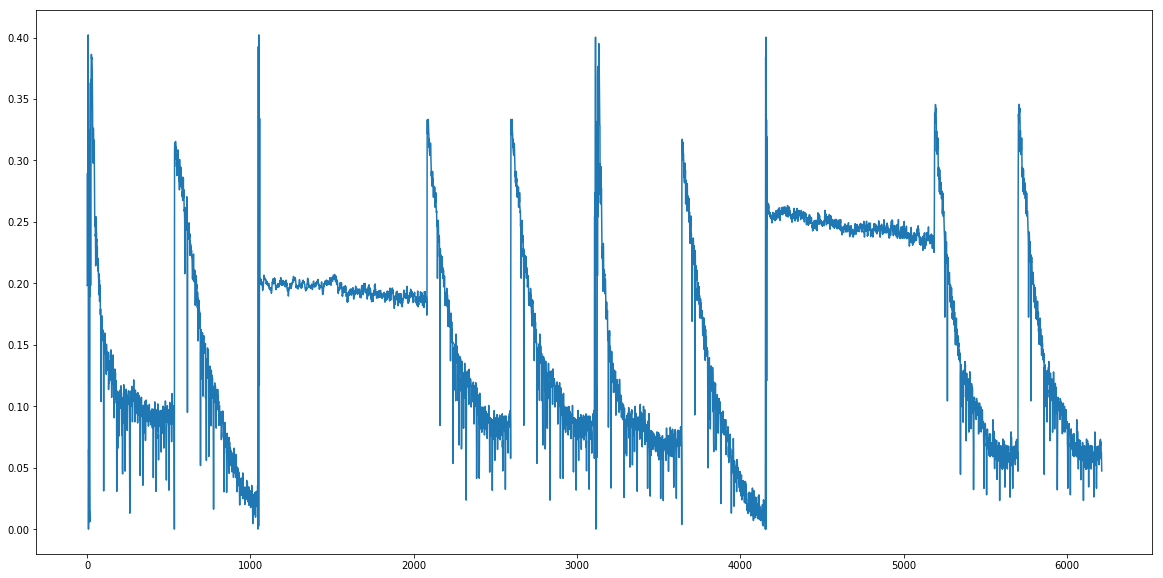

In [5]:
nasougamhsw = np.load('trained_pipes2/fs_2_2.npz')
clf = nasougamhsw['model']
# clf2 = np.array([gamhmene['model']])
feat = list(clf[0].named_steps['feature_selection'].get_support(indices = True))

feat_score = list(clf[0].named_steps['feature_selection'].scores_)
# print(feat_score)
plt.figure(figsize= (20,10))
plt.plot(feat_score)

# asd = get_feat_id(feat,1)
# ftfn =[]
# for i in range(len(feat)):
#     if feat[i]>=3107:
#         ftfn.append(feat[i])
# print(len(ftfn))

In [12]:
data_X = deepcopy(X[2]) ; data_Y = deepcopy(Y[2])
trmp = data_X[1]
# trmp.shape
# asda = clf[0].predict(trmp)
print clf[0]
print clf[0].predict(trmp)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SelectKBest(k=1000,
      score_func=<function mutual_info_classif at 0x7fa94e82d410>)), ('decomp', PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
[ 0.  0.  0. ...,  1.  1.  1.]
